In [1]:
import os
import pickle
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dotenv
dotenv.load_dotenv()

True

In [2]:
plt.style.use('../style/style-formal.mplstyle')

In [8]:
RESEARCH_DATA = os.environ.get("RESEARCH_DATA")

EL = "attempt_1"

curr_dir = os.getcwd()
root_dir = os.path.dirname(curr_dir)
dot_exp_config_file = os.path.join(root_dir, ".experiment_config")
EXP_CONFIG = json.load(open(dot_exp_config_file, "r"))

LINE_CNT = EXP_CONFIG["target_lines"][-1]
MUT_CNT = EXP_CONFIG["mutation_cnt"][-1]
TCS_REDUCTION = EXP_CONFIG["tcs_reduction"]

EXP_LIST = ["", "_sbfl", "_mbfl"]
EXPERIMENT_TYPE = "featureGroup"


TOP_N = [1, 3, 5, 10]

dlfl_out_base_dir = os.path.join(RESEARCH_DATA, EL, "dlfl_out")


EXP_DICT = {
    "": {
        "key": "Normal"
    },
    "_sbfl": {
        "key": "SBFL"
    },
    "_mbfl": {
        "key": "MBFL"
    }
}
for exp in EXP_LIST:

    dlfl_raw_dir_exp = os.path.join(dlfl_out_base_dir, f"experiment_raw_results{exp}")
    assert os.path.exists(dlfl_raw_dir_exp), f"Directory {dlfl_raw_dir_exp} does not exist."
    EXP_DICT[exp]["dlfl_raw_dir"] = dlfl_raw_dir_exp

dlfl_information_dir = os.path.join(dlfl_out_base_dir, "experiment_information_results")
if not os.path.exists(dlfl_information_dir):
    os.makedirs(dlfl_information_dir)


In [9]:
def calculate_exp_results():
    default = {
        "topN": {n: [] for n in TOP_N},
        "mfr_list": [],
        "mar_list": [],

    }
    exp_results = {}
    for exp, exp_info in EXP_DICT.items():
        method_name = f"lineCnt{LINE_CNT}_mutCnt{MUT_CNT}_tcs{TCS_REDUCTION}"
        exp_results[exp_info["key"]] = copy.deepcopy(default)

        for rid in range(1, EXP_CONFIG["num_repeats"]+1):
            result_path = os.path.join(exp_info["dlfl_raw_dir"], f"repeat_{rid}", "methods", method_name, "final_results.json")
            if not os.path.exists(result_path):
                raise FileNotFoundError(f"Result file not found: {result_path}")
            
            with open(result_path, "r") as f:
                result = json.load(f)["total"]

            for n in TOP_N:
                exp_results[exp_info["key"]]["topN"][n].append(result[f"top{n}"])

            exp_results[exp_info["key"]]["mfr_list"].append(result["mfr"])
            exp_results[exp_info["key"]]["mar_list"].append(result["mar"])

        exp_results[exp_info["key"]]["topN_mean"] = {n: np.mean(exp_results[exp_info["key"]]["topN"][n]) for n in TOP_N}
        exp_results[exp_info["key"]]["topN_std"] = {n: np.std(exp_results[exp_info["key"]]["topN"][n]) for n in TOP_N}
        exp_results[exp_info["key"]]["mfr_mean"] = np.mean(exp_results[exp_info["key"]]["mfr_list"])
        exp_results[exp_info["key"]]["mfr_std"] = np.std(exp_results[exp_info["key"]]["mfr_list"])
        exp_results[exp_info["key"]]["mar_mean"] = np.mean(exp_results[exp_info["key"]]["mar_list"])
        exp_results[exp_info["key"]]["mar_std"] = np.std(exp_results[exp_info["key"]]["mar_list"])

    return exp_results

In [10]:
exp_result = calculate_exp_results()

In [13]:
# Save the results to a csv
def save_results_to_csv(exp_result, exp_type="lineCnt"):
    if exp_type == "lineCnt":
        std = EXP_CONFIG["target_lines"][-1]
    elif exp_type == "mutCnt":
        std = EXP_CONFIG["mutation_cnt"][-1]
    elif exp_type == "tcsReduction":
        std = TCS_REDUCTION
    else:
        std = ""
    csv_path = os.path.join(dlfl_information_dir, f"average_results-{exp_type}{std}.csv")

    data = []
    for method, results in exp_result.items():
        row = {
            "Technique": method,
            "Top-1_mean": results["topN_mean"][1],
            "Top-1_std": results["topN_std"][1],
            "Top-3_mean": results["topN_mean"][3],
            "Top-3_std": results["topN_std"][3],
            "Top-5_mean": results["topN_mean"][5],
            "Top-5_std": results["topN_std"][5],
            "Top-10_mean": results["topN_mean"][10],
            "Top-10_std": results["topN_std"][10],
            "MFR_mean": results["mfr_mean"],
            "MFR_std": results["mfr_std"],
            "MAR_mean": results["mar_mean"],
            "MAR_std": results["mar_std"]
        }
        data.append(row)

    df = pd.DataFrame(data)
    df.to_csv(csv_path, index=False)

    

In [14]:
save_results_to_csv(exp_result, exp_type=EXPERIMENT_TYPE)

In [21]:
def plot_topN_line_graphs(exp_result, save_graphs=True, exp_type="lineCnt"):

    if save_graphs:
        graphs_dir = os.path.join(dlfl_information_dir, "graphs")
        if not os.path.exists(graphs_dir):
            os.makedirs(graphs_dir)

    if exp_type == "lineCnt":
        x_values = EXP_CONFIG["target_lines"]
        exp_std = EXP_CONFIG["target_lines"][-1]
        title = "Impact of %TargetLines on Top-{}"
        xLabel = '% of Target Lines'
    elif exp_type == "mutCnt":
        x_values = EXP_CONFIG["mutation_cnt"]
        exp_std = EXP_CONFIG["mutation_cnt"][-1]
        title = "Impact of #Mutants on Top-{}"
        xLabel = '# of Mutants'
    elif exp_type == "tcsReduction":
        x_values = ["All", "Reduced"]
        exp_std = TCS_REDUCTION
        title = "Impact of TCS Reduction on Top-{}"
        xLabel = 'TCS Reduction'
    else:
        x_values = [exp_data["key"] for exp, exp_data in EXP_DICT.items()]
        exp_std = ""
        title = "Impact of FeatureGroup on Top-{}"
        xLabel = 'Experiment Type'

    for i, top_n in enumerate(TOP_N, 1):
        mean = [exp_result[method][f"topN_mean"][top_n] for method in exp_result]
        std = [exp_result[method][f"topN_std"][top_n] for method in exp_result]
        line1 = plt.plot(x_values, mean, label=f"DLFL", marker='x', linewidth=2)
        # color = line1[0].get_color()
        # plt.fill_between(x_values,
        #                  [m - s for m, s in zip(mean, std)],
        #                  [m + s for m, s in zip(mean, std)],
        #                  alpha=0.3, color=color, label=f"DLFL ±1σ")
        
        plt.ylim(0, 100)
        plt.legend([line1[0]], [f"DLFL"], fontsize=12)
        plt.title(title.format(top_n), fontsize=17)
        plt.xlabel(xLabel, fontsize=15)
        plt.ylabel(f'Top-{top_n}', fontsize=15)
        plt.xticks(x_values, fontsize=12)
        plt.yticks(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tick_params(axis='both', which='major', labelsize=12)

        plt.tight_layout()
        plt.savefig(os.path.join(graphs_dir, f"topN_line_graph_{top_n}-{exp_type}{exp_std}.png"), dpi=300)
        plt.show()
        plt.close()

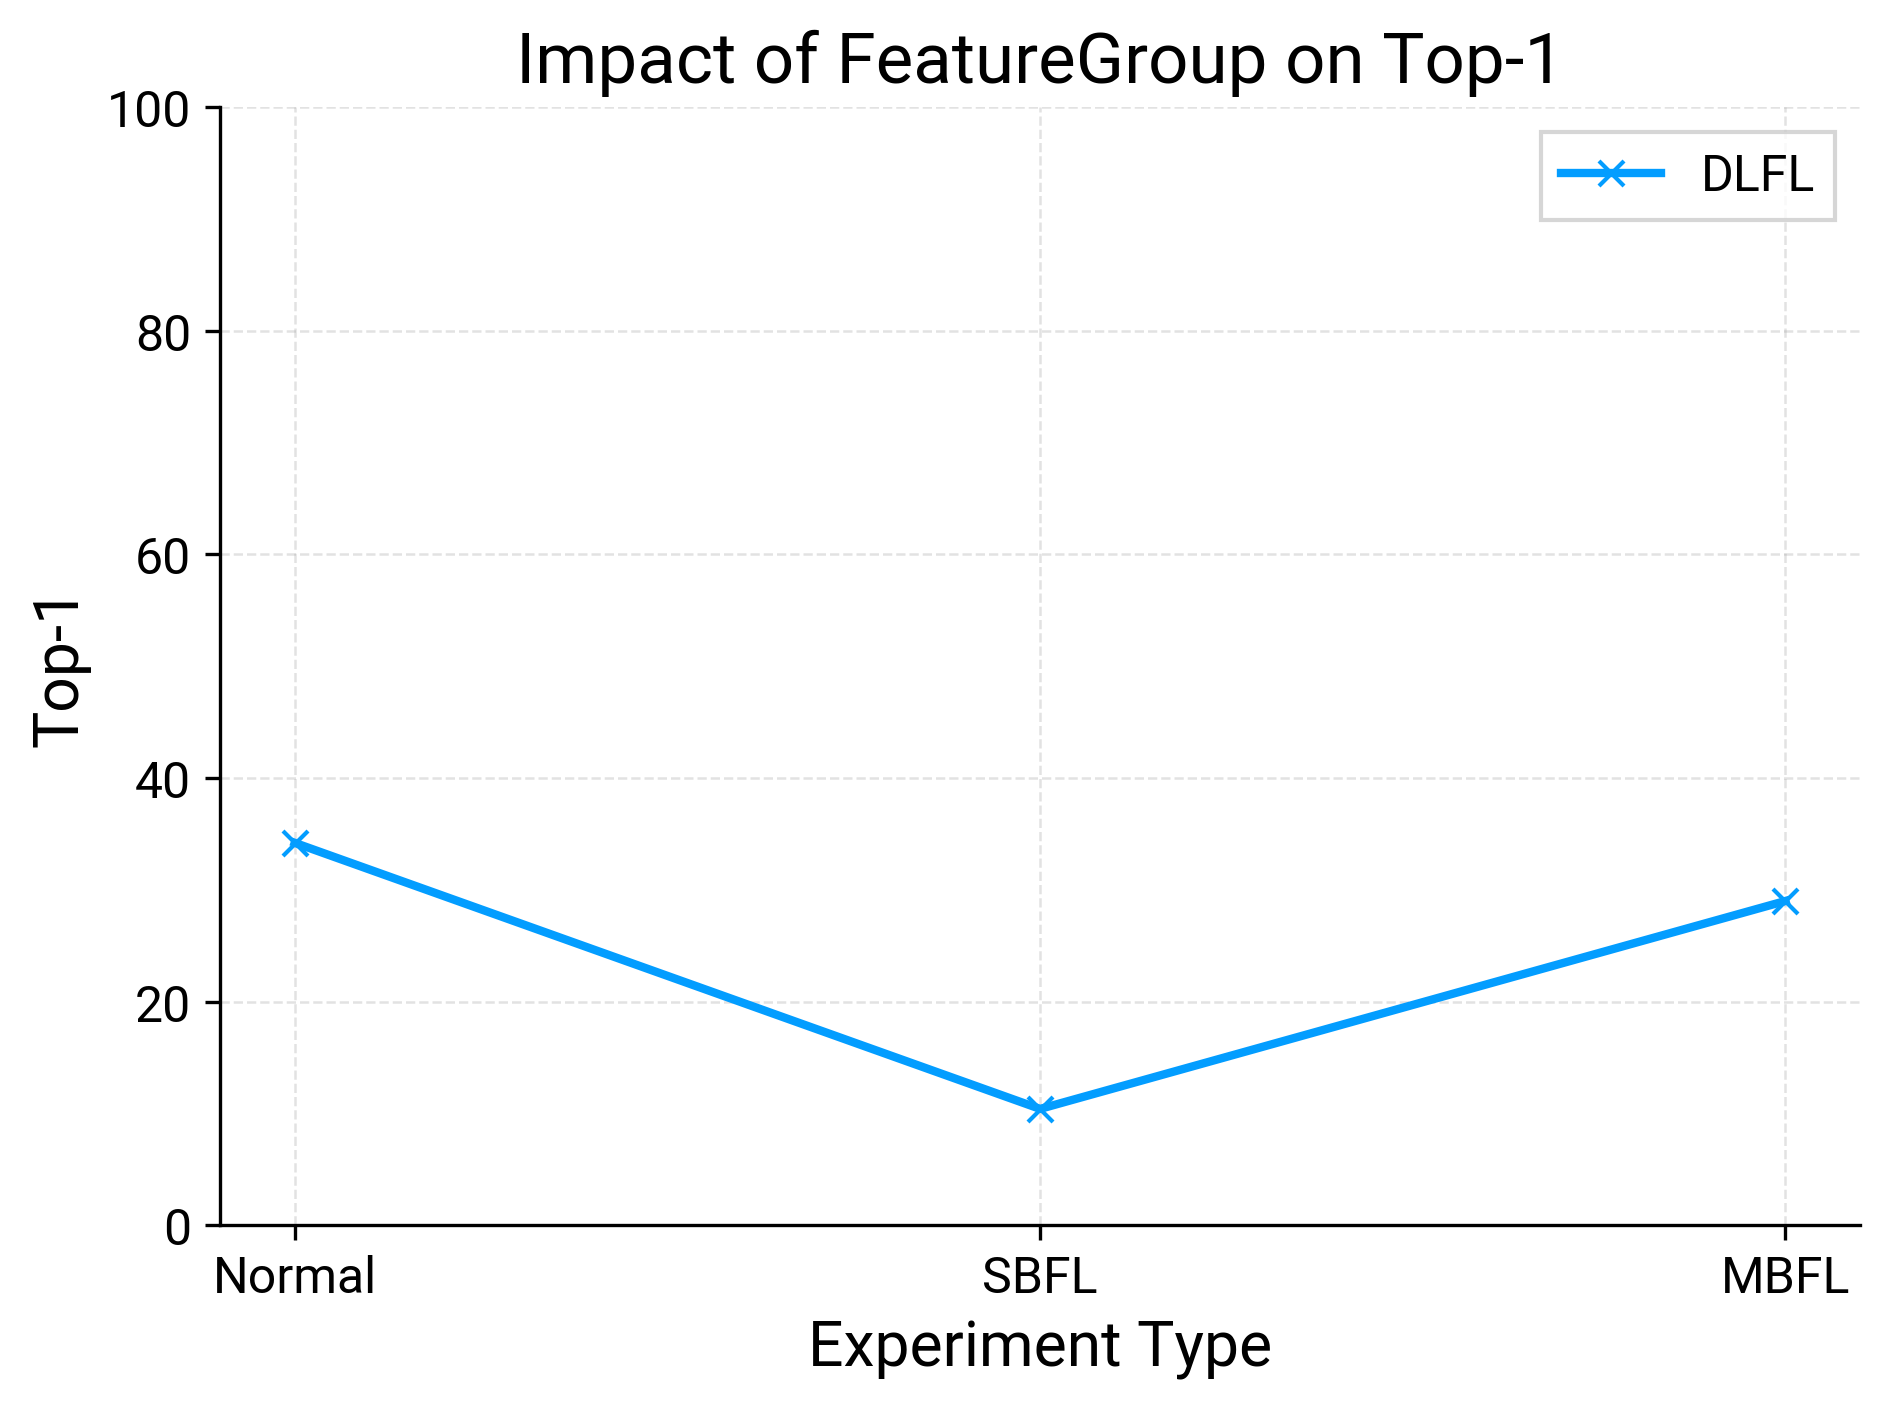

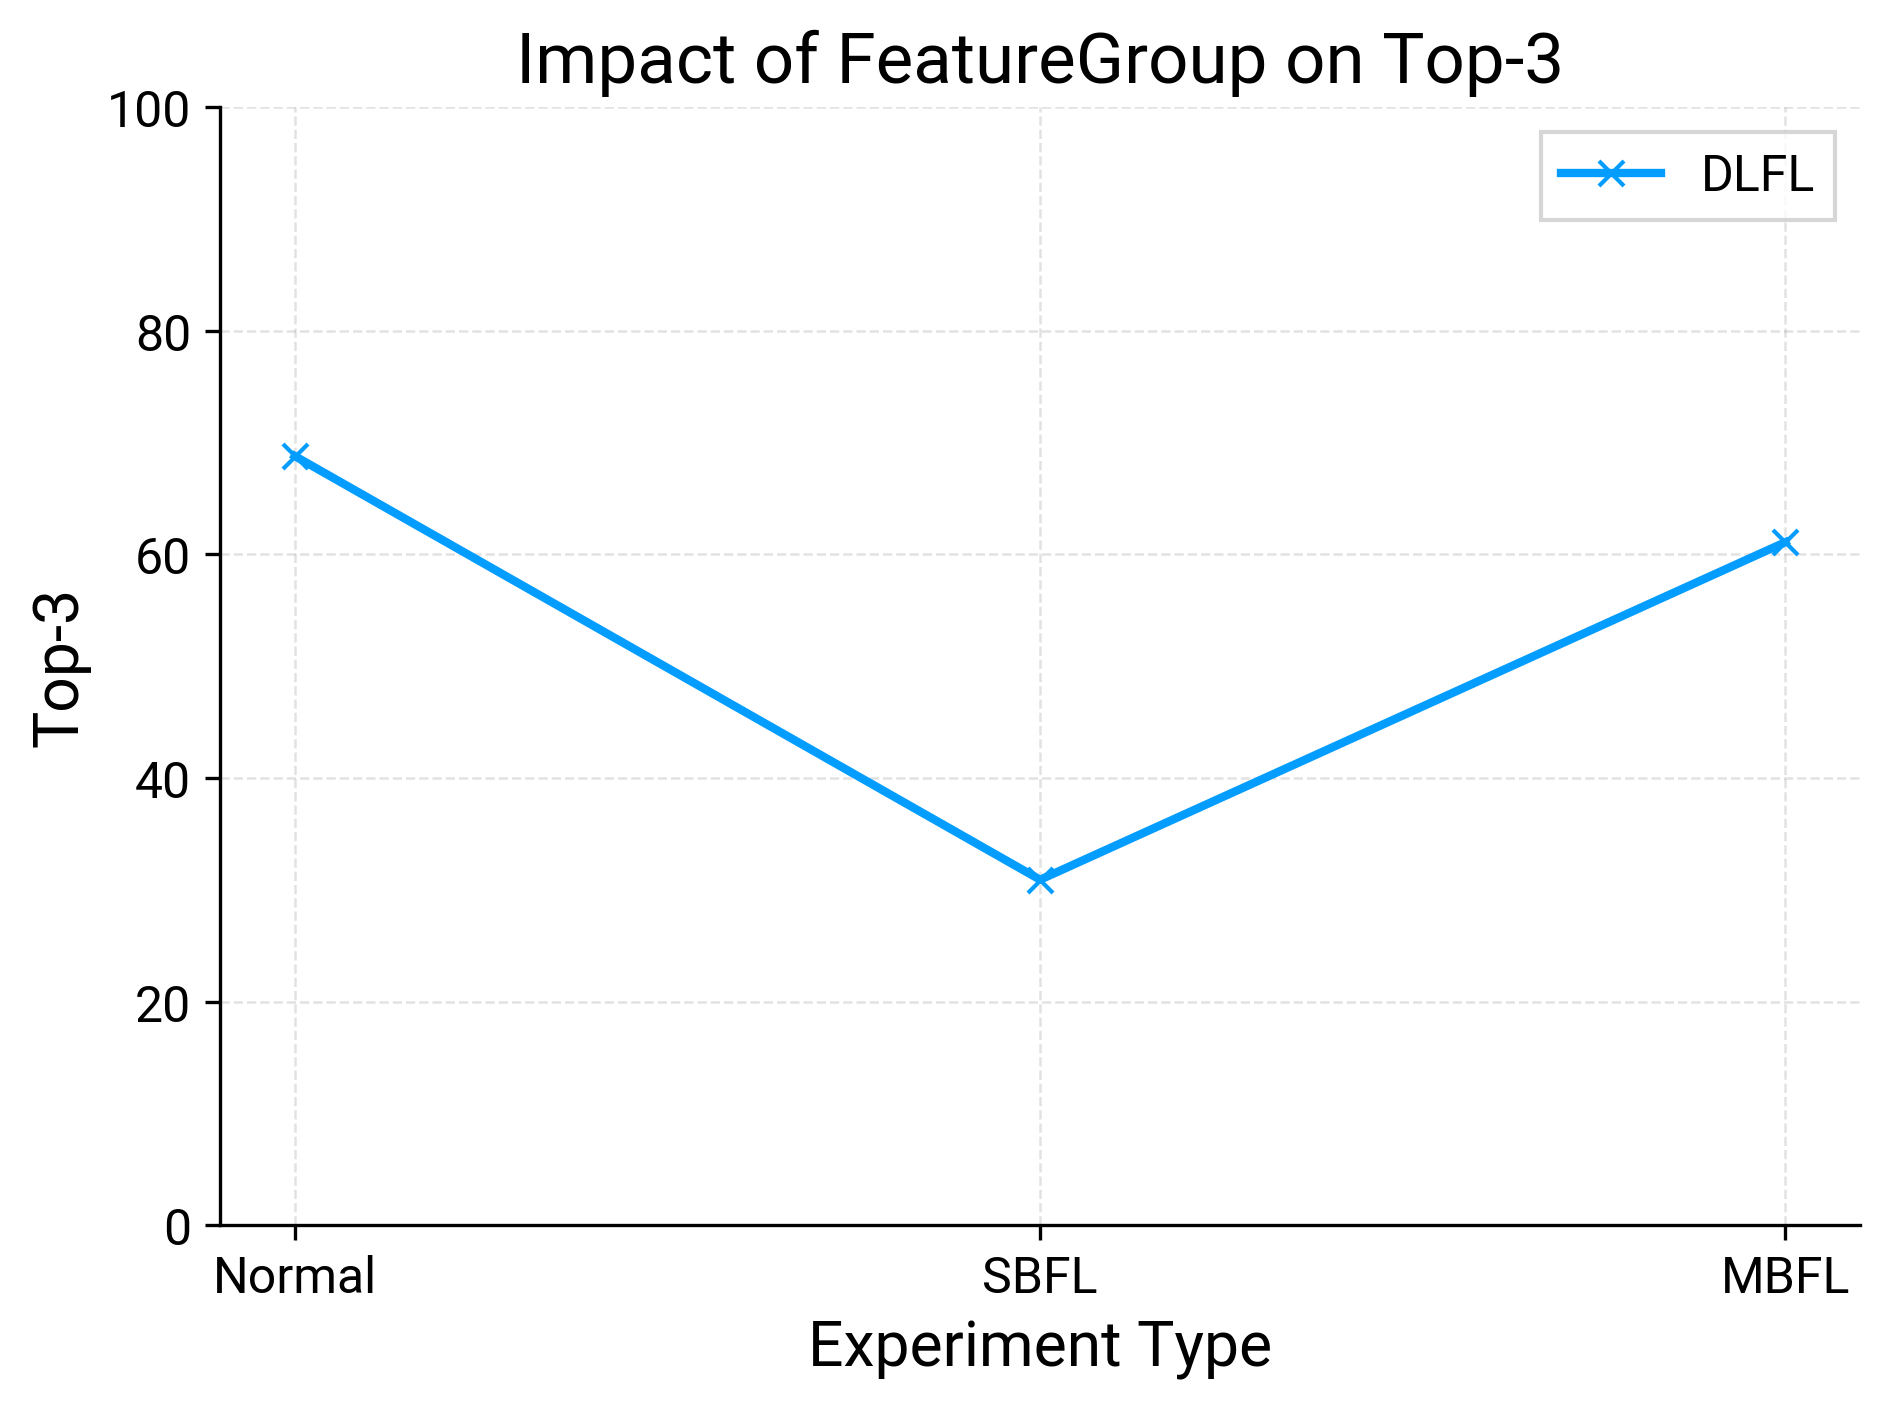

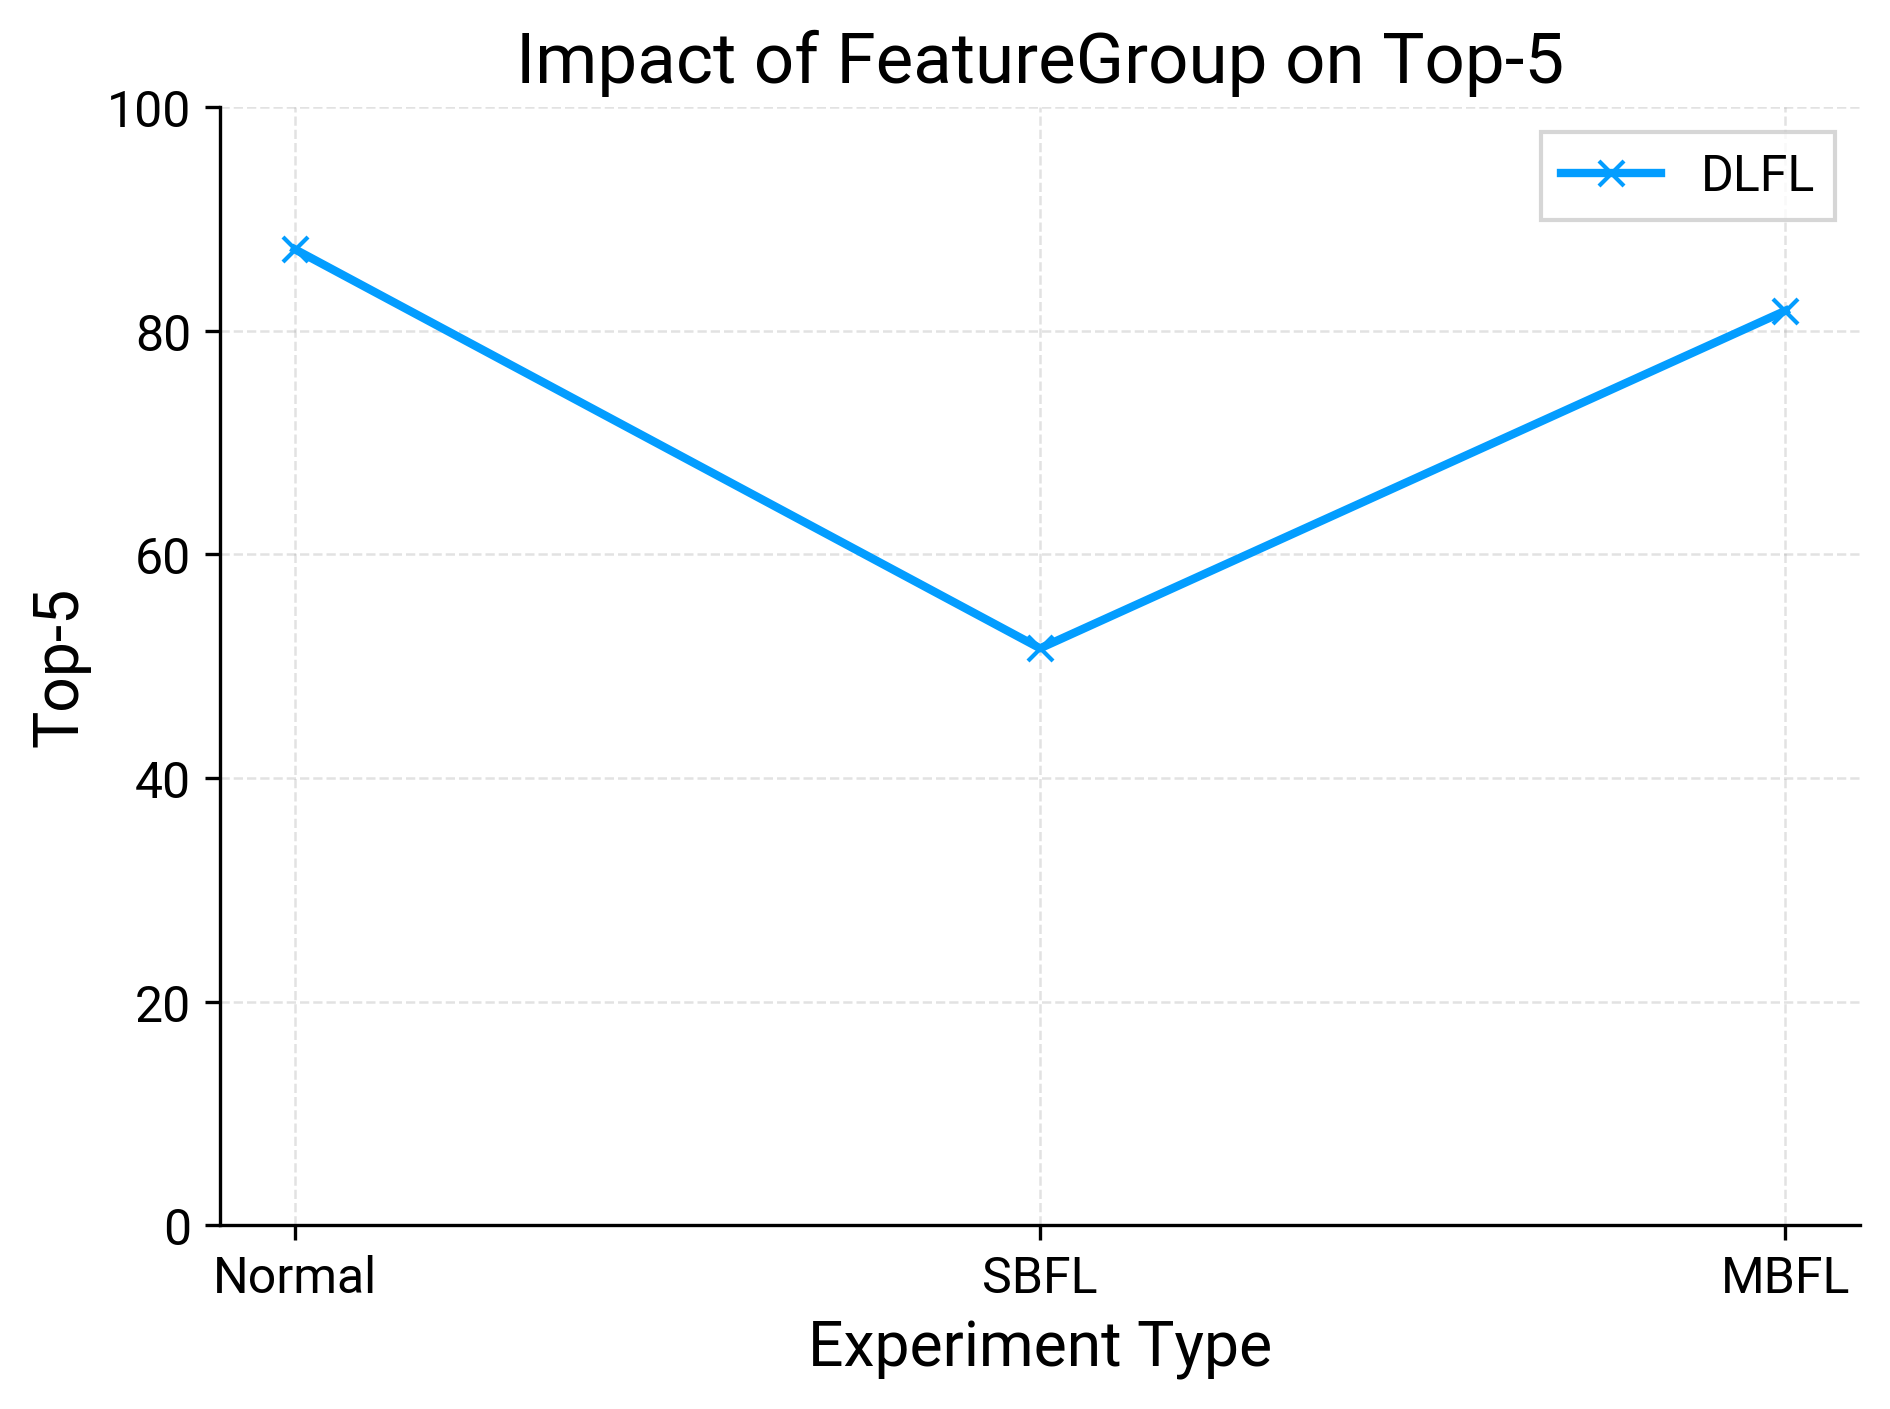

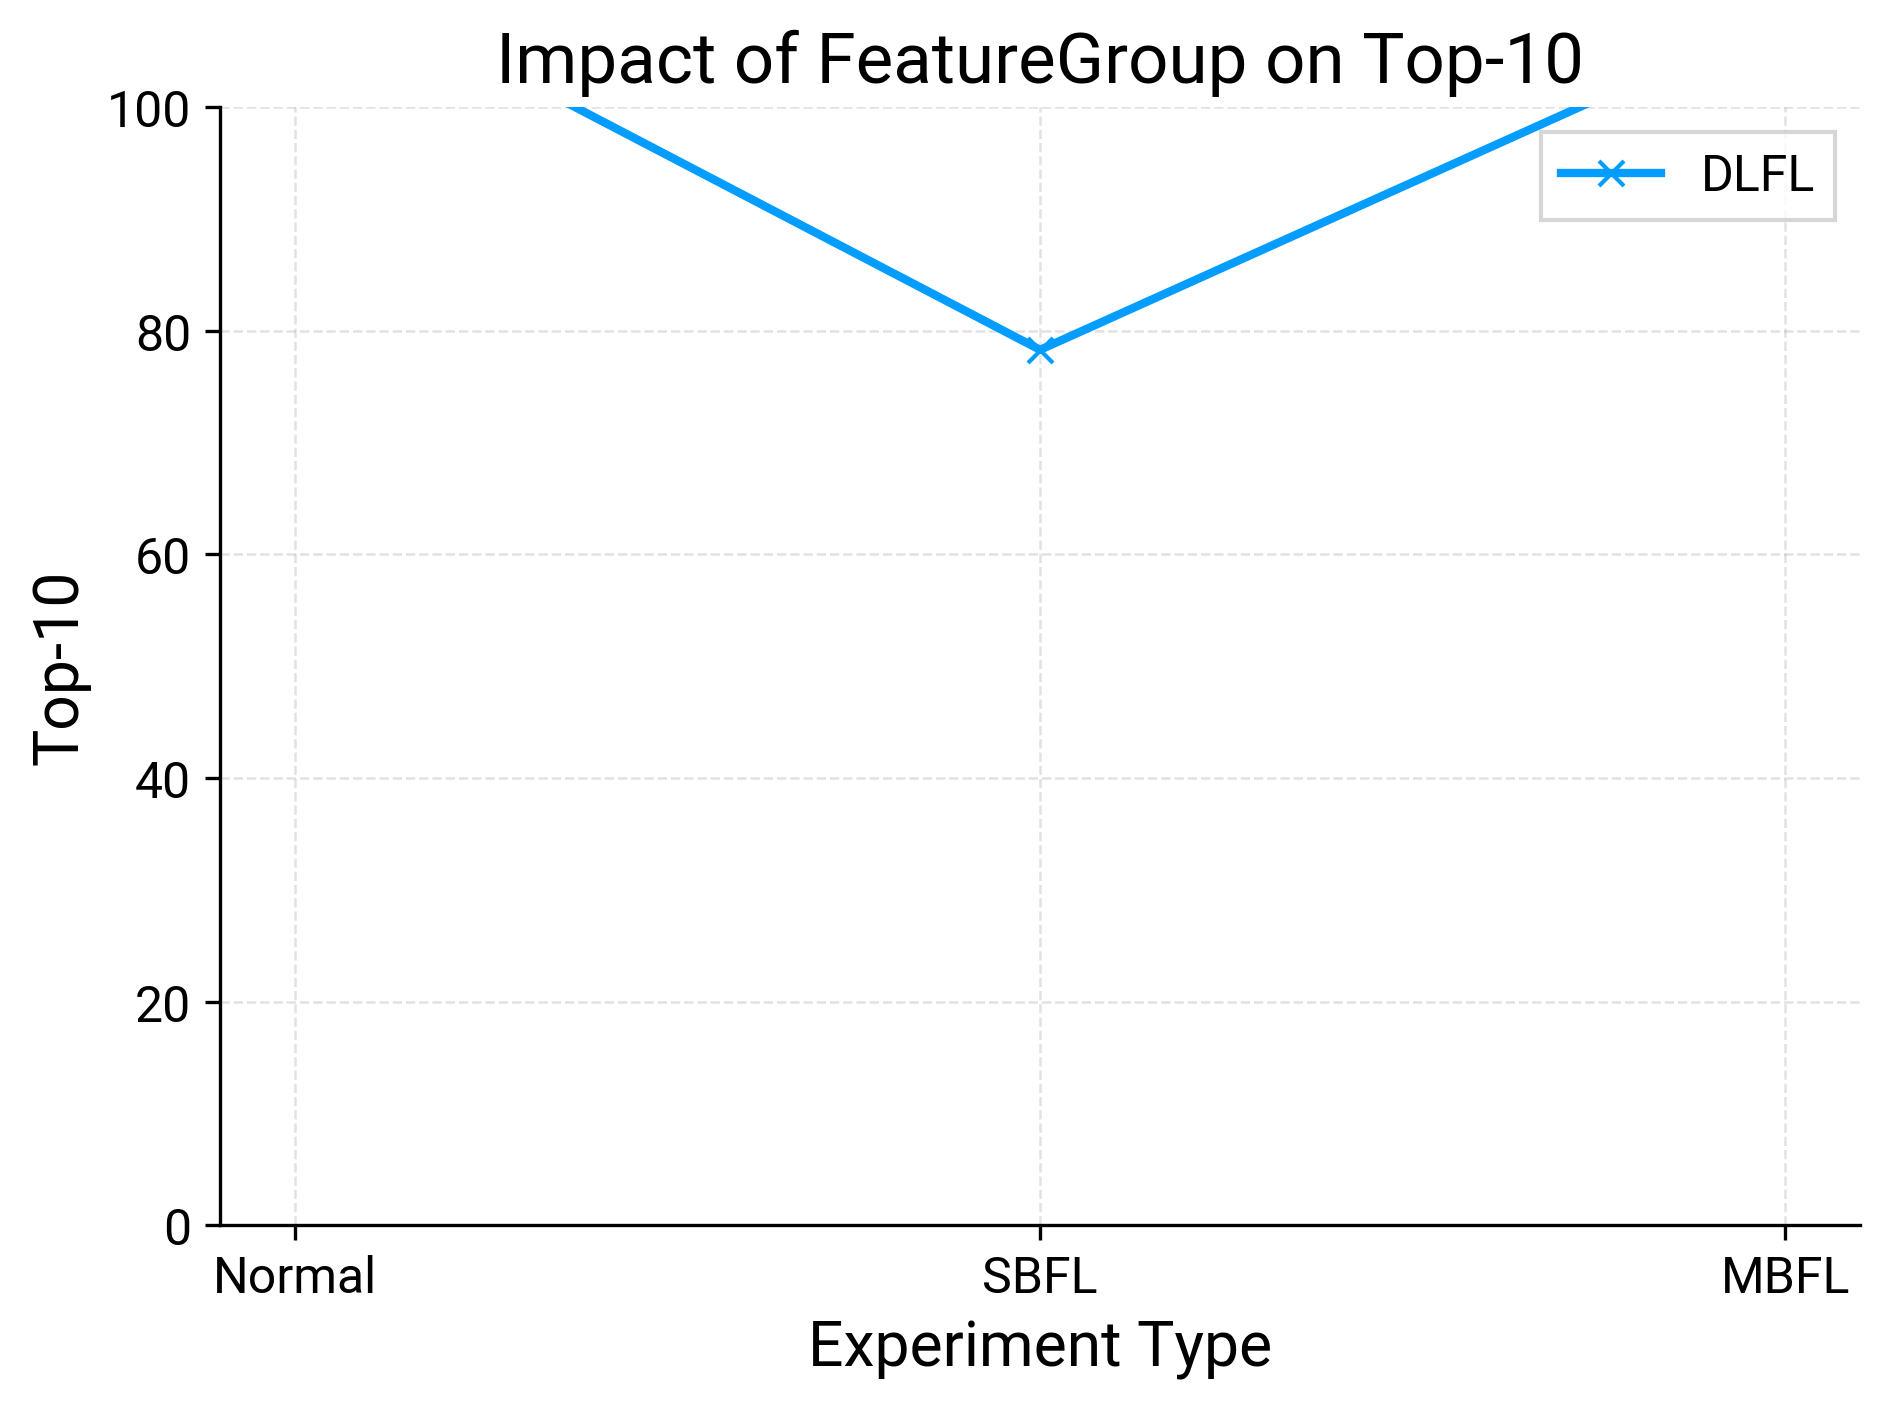

In [22]:
plot_topN_line_graphs(exp_result, save_graphs=True, exp_type=EXPERIMENT_TYPE)

In [23]:
def plot_mfr_mar_line_graphs(exp_result, save_graphs=True, exp_type="lineCnt"):
    if save_graphs:
        graphs_dir = os.path.join(dlfl_information_dir, "graphs")
        if not os.path.exists(graphs_dir):
            os.makedirs(graphs_dir)

    if exp_type == "lineCnt":
        x_values = EXP_CONFIG["target_lines"]
        exp_std = EXP_CONFIG["target_lines"][-1]
        title_mfr = "Impact of %TargetLines on MFR"
        title_mar = "Impact of %TargetLines on MAR"
        xLabel = '% of Target Lines'
    elif exp_type == "mutCnt":
        x_values = EXP_CONFIG["mutation_cnt"]
        exp_std = EXP_CONFIG["mutation_cnt"][-1]
        title_mfr = "Impact of #Mutants on MFR"
        title_mar = "Impact of #Mutants on MAR"
        xLabel = '# of Mutants'
    elif exp_type == "tcsReduction":
        x_values = ["All", "Reduced"]
        exp_std = TCS_REDUCTION
        title_mfr = "Impact of TCS Reduction on MFR"
        title_mar = "Impact of TCS Reduction on MAR"
        xLabel = 'TCS Reduction'
    else:
        x_values = [exp_data["key"] for exp, exp_data in EXP_DICT.items()]
        exp_std = ""
        title_mfr = "Impact of FeatureGroup on MFR"
        title_mar = "Impact of FeatureGroup on MAR"
        xLabel = 'Experiment Type'

    # MFR
    mean_mfr = [exp_result[method]["mfr_mean"] for method in exp_result]
    std_mfr = [exp_result[method]["mfr_std"] for method in exp_result]
    line1 = plt.plot(x_values, mean_mfr, label="DLFL", marker='x', linewidth=2)
    # color = line1[0].get_color()
    # plt.fill_between(x_values,
    #                  [m - s for m, s in zip(mean_mfr, std_mfr)],
    #                  [m + s for m, s in zip(mean_mfr, std_mfr)],
    #                  alpha=0.3, color=color, label="DLFL ±1σ")

    plt.legend([line1[0]], [f"DLFL"], fontsize=12)
    plt.title(title_mfr, fontsize=17)
    plt.xlabel(xLabel, fontsize=12)
    plt.ylabel("MFR", fontsize=12)
    plt.xticks(x_values, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.tight_layout()
    if save_graphs:
        plt.savefig(os.path.join(graphs_dir, f"mfr_line_graph-{exp_type}{exp_std}.png"), dpi=300)
    plt.show()
    plt.close()

    # MAR
    mean_mar = [exp_result[method]["mar_mean"] for method in exp_result]
    std_mar = [exp_result[method]["mar_std"] for method in exp_result]
    line2 = plt.plot(x_values, mean_mar, label="DLFL", marker='x', linewidth=2)
    # color = line2[0].get_color()
    # plt.fill_between(x_values,
    #                  [m - s for m, s in zip(mean_mar, std_mar)],
    #                  [m + s for m, s in zip(mean_mar, std_mar)],
    #                  alpha=0.3, color=color, label="DLFL ±1σ")

    plt.legend([line2[0]], [f"DLFL"], fontsize=12)
    plt.title(title_mar, fontsize=17)
    plt.xlabel(xLabel, fontsize=12)
    plt.ylabel("MAR", fontsize=15)
    plt.xticks(x_values, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.tight_layout()
    if save_graphs:
        plt.savefig(os.path.join(graphs_dir, f"mar_line_graph-{exp_type}{exp_std}.png"), dpi=300)
    plt.show()
    plt.close()

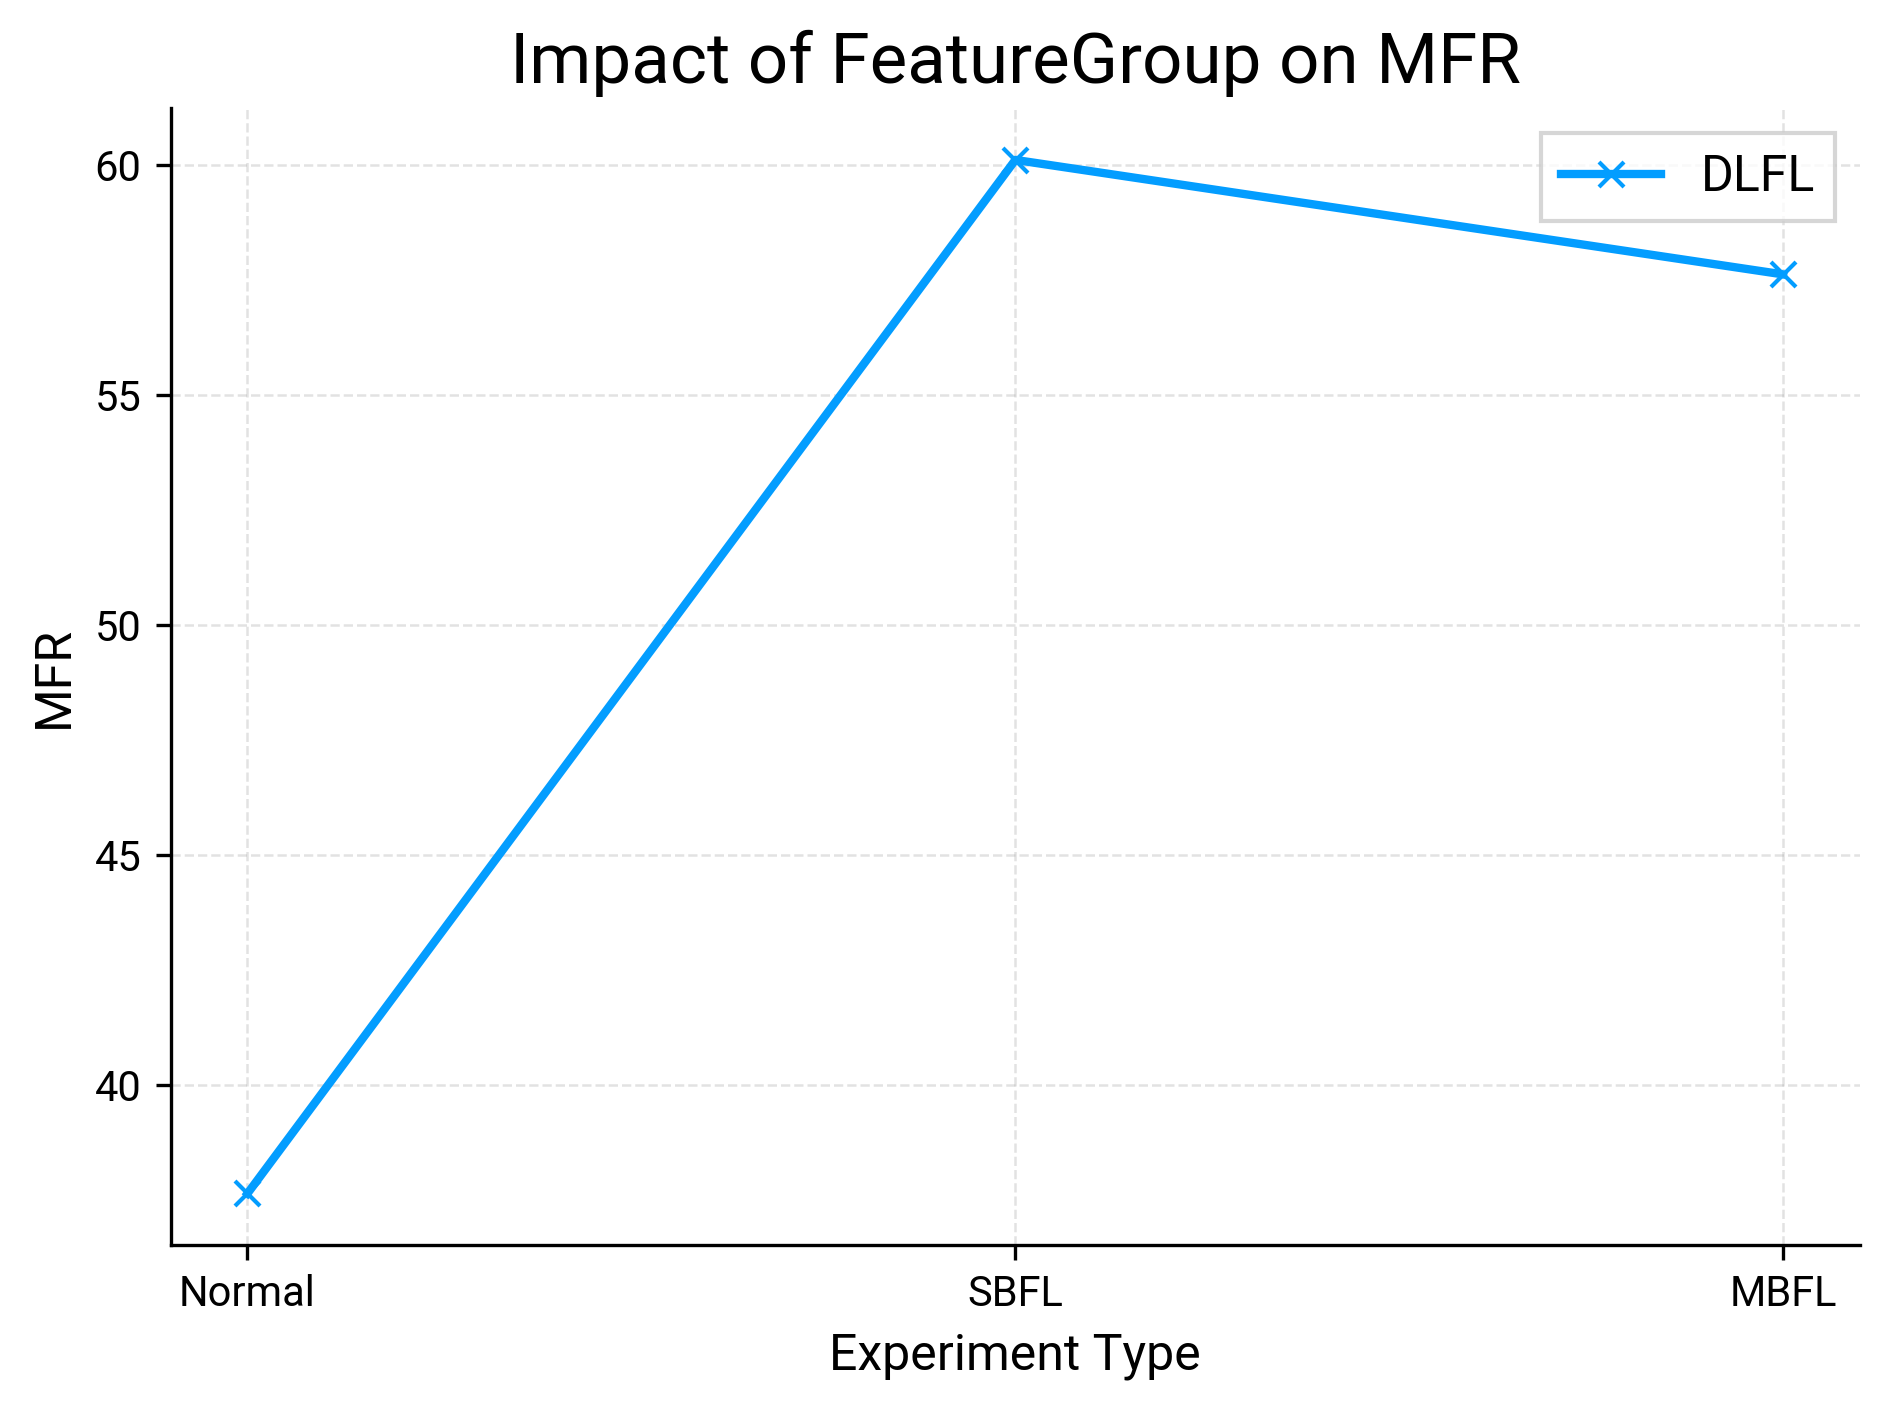

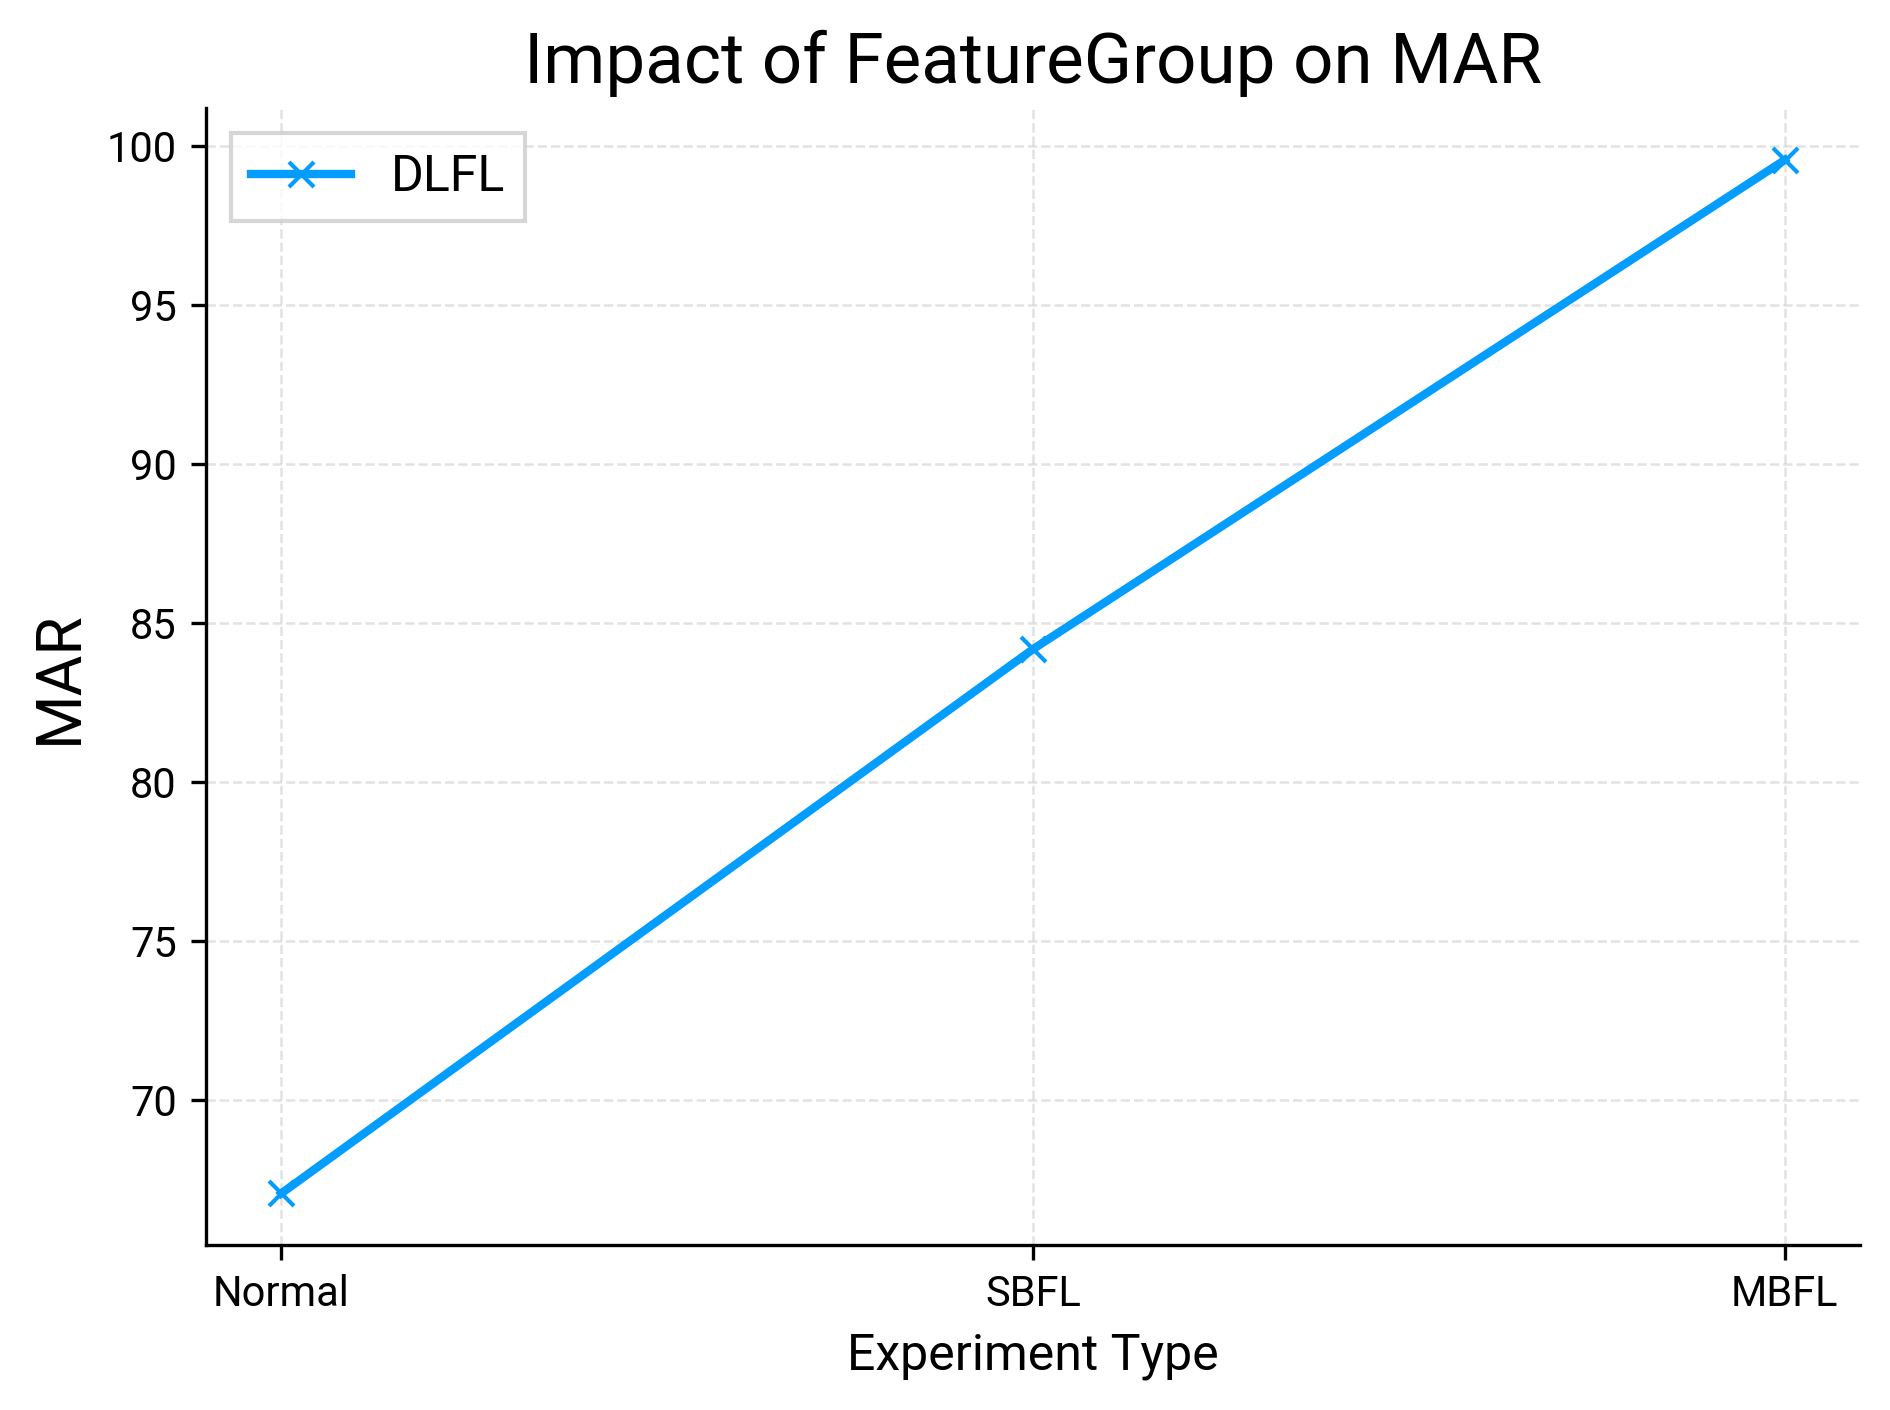

In [24]:
plot_mfr_mar_line_graphs(exp_result, save_graphs=True, exp_type=EXPERIMENT_TYPE)